In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch, os, sys
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from copy import deepcopy

sys.path.append('../')
from utils.arg_parser import parse_exp_args

## Input fields

In [4]:
EXP_ID = 'vnn_delta_100_5'
figsize = (15,10)

In [5]:
def parse_loss_file(file):
    with open(file, 'r') as f:
        data = f.readlines()
    epochs = []
    losses = []
    for item in data:
        epoch, loss = tuple(item.strip().split(','))
        epochs.append(int(epoch))
        losses.append(float(loss))
    return np.array(epochs), np.array(losses)

In [6]:
log_dir = os.path.join('../','logs', EXP_ID)
train_loss_file = os.path.join(log_dir, 'train_loss.txt')
test_loss_file = os.path.join(log_dir, 'test_loss.txt')

In [7]:
train_ep, train_loss = parse_loss_file(train_loss_file)
test_ep, test_loss = parse_loss_file(test_lo`ss_file)

## Plot loss curves

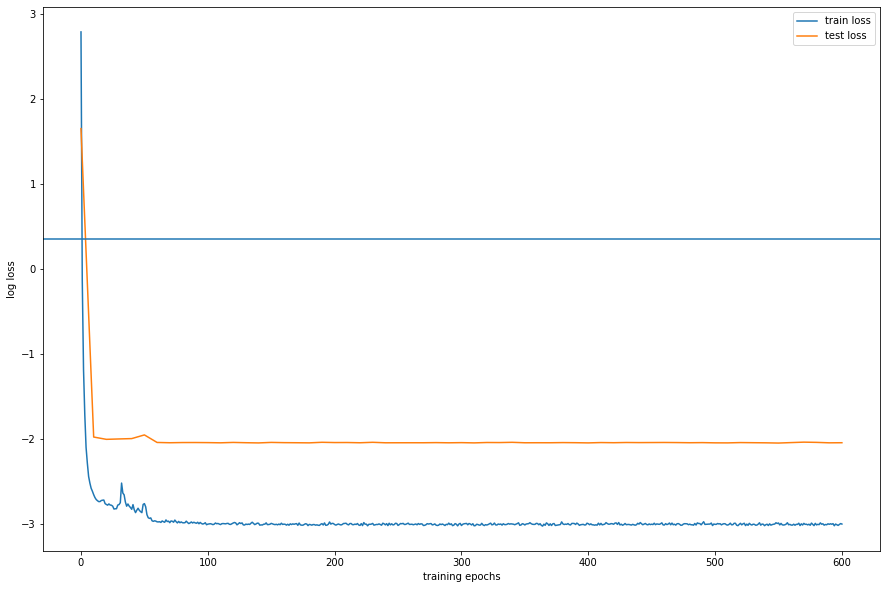

In [9]:
fig=plt.figure(figsize=figsize)
plt.plot(train_ep, np.log(train_loss), label='train loss')
plt.plot(test_ep, np.log(test_loss), label='test loss')
plt.axhline(0.35)
plt.xlabel('training epochs')
plt.ylabel('log loss')
plt.legend()
plt.show()

In [33]:
def get_best_model(log_dir, test_ep, test_loss):
    saved_models = []
    model_save_epochs = []
    for item in sorted(os.listdir(log_dir)):
        if'model_' in item:
            saved_models.append(item)
            ep = int(item.split('_')[-1])
            model_save_epochs.append(ep)
    model_save_epochs = sorted(model_save_epochs)
    loss_idxs = [list(test_ep.flatten()).index(x) for x in model_save_epochs]
    loss_idxs = sorted(loss_idxs)
    best_model_ep = model_save_epochs[np.argmin(test_loss[loss_idxs])]
    print('Best model epoch is {}'.format(best_model_ep))
    best_model_file = os.path.join(log_dir, 'model_ep_'+str(best_model_ep))
    
    assert os.path.exists(best_model_file)
    return best_model_file

In [35]:
best_model_file = get_best_model(log_dir, test_ep, test_loss)
loaded_state_dic = torch.load(best_model_file)

used_args_file = os.path.join(log_dir, 'args.txt')
args = parse_exp_args(used_args_file)
loaded_model = args.model(input_size=args.input_size, output_size=args.output_size,
                           actv_type=args.actv,
                           num_layers=args.num_layers,
                           hidden_size=args.hidden, 
                           bias=args.bias, 
                           use_bn=args.bn)

if 'module' in list(loaded_state_dic.keys())[0]:
    mod_state_dic = OrderedDict()
    for k,v in loaded_state_dic.items():
        mod_k = k.strip('module.')
        if mod_k not in loaded_model.state_dict():
            print('skipping {}'.format(mod_k))
            continue
        mod_state_dic[mod_k] = loaded_state_dic[k]

loaded_model.load_state_dict(mod_state_dic)

Best model epoch is 140
skipping fcs.0.bn.num_batches_track
skipping fcs.1.bn.num_batches_track
skipping fcs.2.bn.num_batches_track
skipping fcs.3.bn.num_batches_track
skipping fcs.4.bn.num_batches_track
skipping fcs.5.bn.num_batches_track
skipping fcs.6.bn.num_batches_track


<All keys matched successfully>

In [36]:
data_used_dir = os.path.join('../data/', args.dataset)
train_X = np.load(os.path.join(data_used_dir, 'train_X.npy')) 
train_y = np.load(os.path.join(data_used_dir, 'train_y.npy')) 
test_X = np.load(os.path.join(data_used_dir, 'test_X.npy')) 
test_y = np.load(os.path.join(data_used_dir, 'test_y.npy')) 
loaded_model.eval()

vanilla_nn(
  (loss): MSELoss()
  (fcs): ModuleList(
    (0): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (1): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (2): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (3): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (4): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (5): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(i

In [37]:
train_y_order = np.argsort(train_y.flatten())
test_y_order = np.argsort(test_y.flatten())

In [38]:
sorted_train_X = train_X[train_y_order]
sorted_train_y = train_y[train_y_order]
sorted_test_X = test_X[test_y_order]
sorted_test_y = test_y[test_y_order]

In [39]:
train_samp = sorted(np.random.choice(train_y.shape[0], size=test_y.shape[0], replace=False))

In [40]:
with torch.no_grad():
    train_pred = loaded_model(torch.FloatTensor(sorted_train_X[train_samp]))
    test_pred = loaded_model(torch.FloatTensor(sorted_test_X))

## Training predictions vs training labels

In [41]:
train_X.shape, test_X.shape

((82972, 56), (20882, 56))

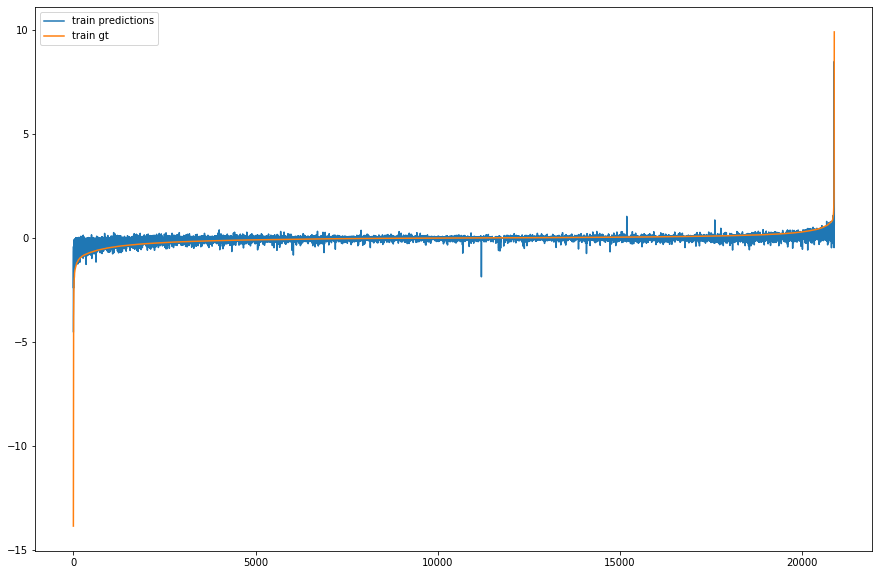

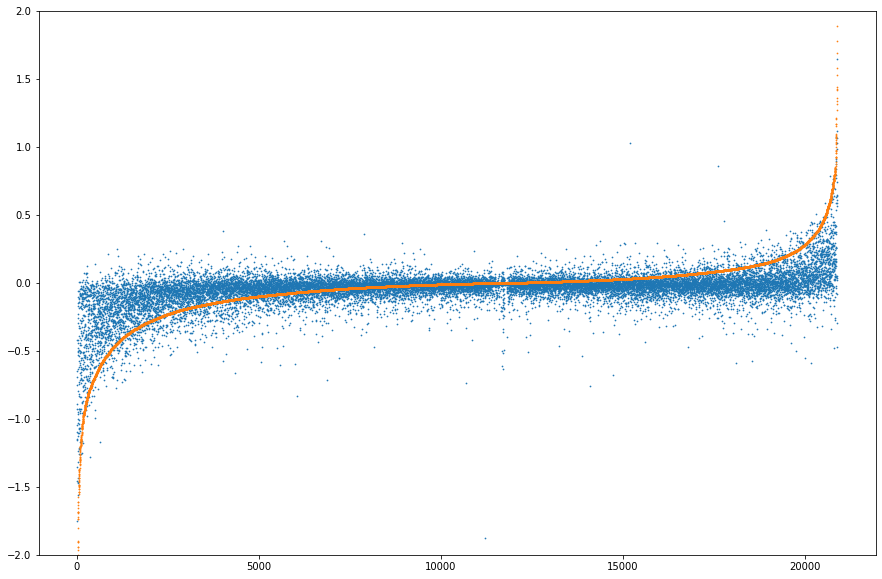

Train MSE 0.0586


In [42]:
fig = plt.figure(figsize=figsize)
plt.plot(train_pred.detach(), label='train predictions' )
plt.plot(sorted_train_y[train_samp], label='train gt')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize)
plt.scatter(np.arange(train_pred.shape[0]), train_pred.detach(), label='train predictions', s=0.5)
plt.scatter(np.arange(sorted_train_y[train_samp].shape[0]), sorted_train_y[train_samp], label='train gt', s=0.5)
plt.ylim(-2,2)
plt.show()

train_MSE = np.mean((train_pred.detach().numpy() - sorted_train_y[train_samp])**2)
print('Train MSE {0:.4f}'.format(train_MSE))

## Testing predictions vs training labels

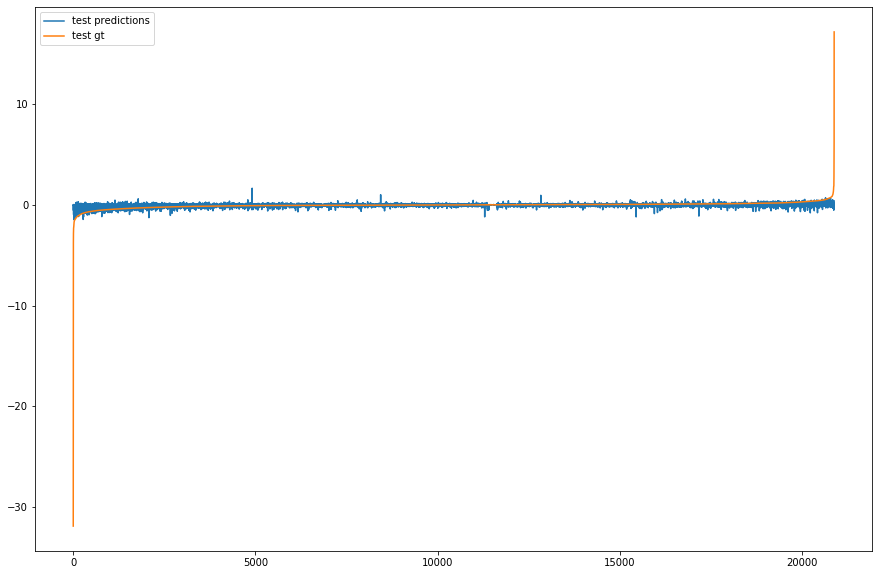

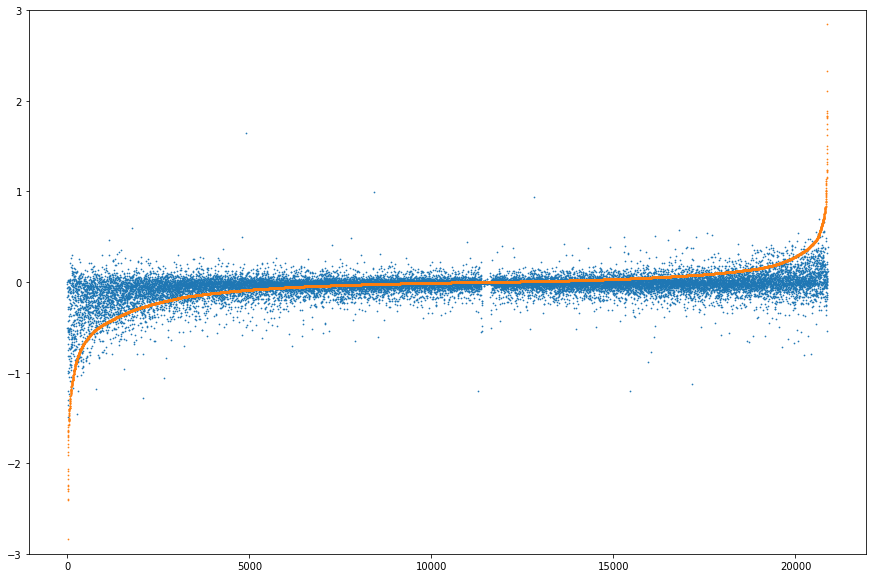

Test MSE 0.1295


In [43]:
fig = plt.figure(figsize=figsize)
plt.plot(test_pred.detach(), label='test predictions' )
plt.plot(sorted_test_y, label='test gt')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize)
plt.scatter(np.arange(test_pred.shape[0]), test_pred.detach(), label='test predictions', s=0.5)
plt.scatter(np.arange(sorted_test_y.shape[0]), sorted_test_y, label='test gt', s=0.5)
plt.ylim(-3,3)
plt.show()

test_MSE = np.mean((test_pred.detach().numpy() - sorted_test_y)**2)
print('Test MSE {0:.4f}'.format(test_MSE))

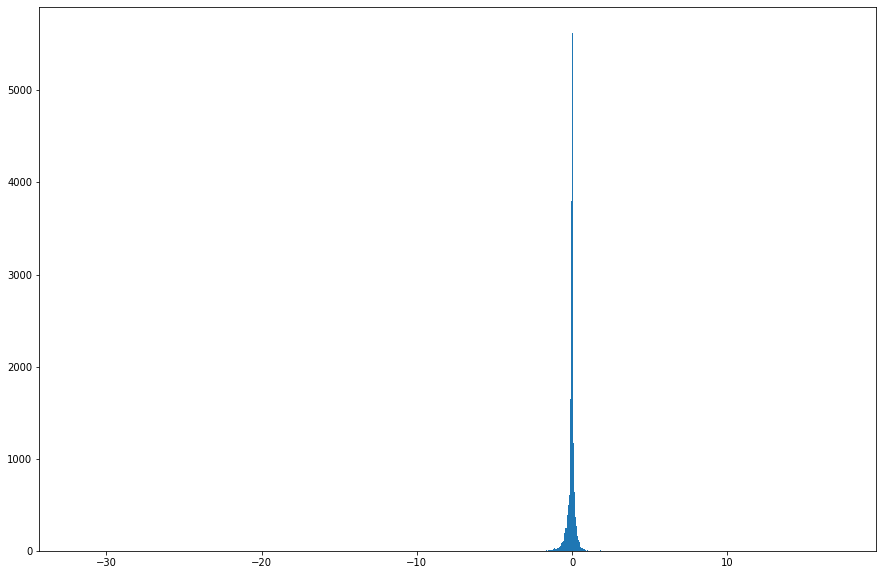

In [44]:
fig = plt.figure(figsize=figsize)
plt.hist(sorted_test_y.flatten(), bins = 1000, label='test gt')
# plt.ylim(0,250)
# plt.hist(test_pred.numpy().flatten(), label='test pred')
plt.show()

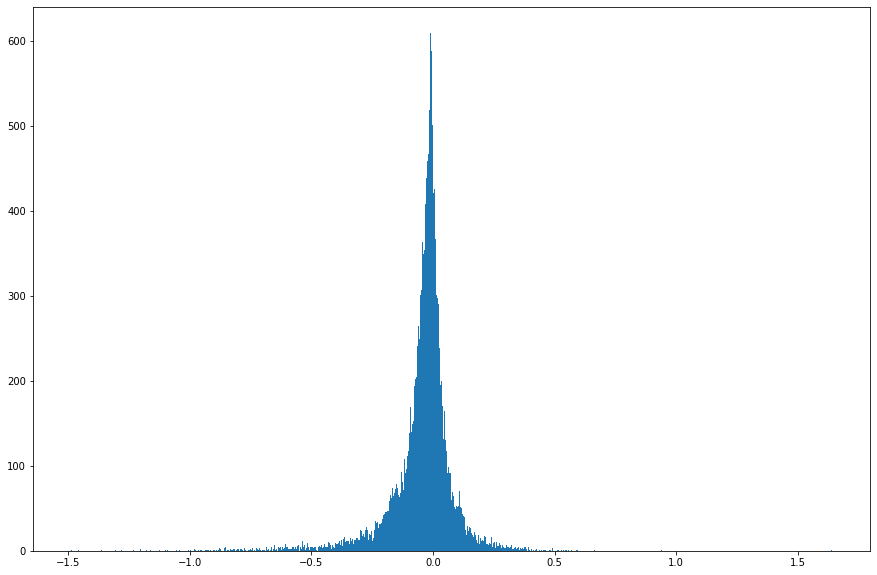

In [45]:
fig = plt.figure(figsize=figsize)
plt.hist(test_pred.numpy().flatten(), bins=1000, label='test pred')
plt.show()

In [46]:
train_MSE = np.mean((train_pred.detach().numpy() - sorted_train_y[train_samp])**2)
test_MSE = np.mean((test_pred.detach().numpy() - sorted_test_y)**2)
print('Train MSE {0:.4f}'.format(train_MSE))
print('Test MSE {0:.4f}'.format(test_MSE))

Train MSE 0.0586
Test MSE 0.1295


In [47]:
print('Predicted test mean {0:.4f}'.format(np.mean(test_pred.detach().numpy())))
print('GT test mean {0:.4f}'.format(np.mean(sorted_test_y)))

Predicted test mean -0.0429
GT test mean -0.0412


In [48]:
print('Predict 0 delta betan {0:.4f}'.format(np.mean(sorted_test_y**2)))
print('Predict mean of GT delta betan {0:.4f}'.format(np.mean((sorted_test_y - np.mean(sorted_test_y))**2)))
print('Predict mean of predicted delta betan {0:.4f}'.format(np.mean((sorted_test_y - np.mean(test_pred.detach().numpy()))**2)))

Predict 0 delta betan 0.1452
Predict mean of GT delta betan 0.1435
Predict mean of predicted delta betan 0.1435


## Test if power affects

In [49]:
train_X.shape

(82972, 56)

In [50]:
first_p = train_X[0:2,:]
mod_p = deepcopy(first_p).reshape(2,-1)

In [51]:
loaded_model.eval()
mod_p = deepcopy(train_X[0:100])
mod_p.shape

(100, 56)

In [52]:
test_powers = np.linspace(4000,10000, 5)
in_list = []
out_list = []
with torch.no_grad():
    for x in test_powers:
        orig_pinj = deepcopy(mod_p[:,-1])
        in_list.append(x - orig_pinj.reshape(-1,1))
        mod_p[:,-1] = x
        output = loaded_model(torch.FloatTensor(mod_p))
        out_list.append(output)
#     plt.plot(test_powers, first_out)
#     plt.plot(test_powers, second_out)
    

In [53]:
out_tensor = torch.cat(out_list, dim=1)
delta_pinj = np.hstack(in_list)

In [54]:
delta_pinj.shape

(100, 5)

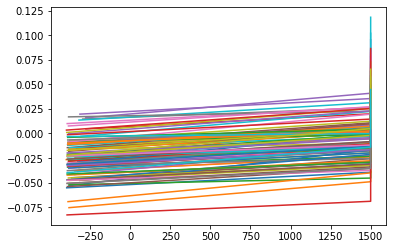

In [55]:
for i in range(out_tensor.shape[0]):
    x = out_tensor[i,:]
    xx = delta_pinj[i,:]
    plt.plot(xx, x)
# plt.xlim(2875,2900)

In [166]:
out_tensor[:,-1]

tensor([-0.5782, -0.2468, -0.5784,  0.6018,  1.2630,  0.5130,  1.0134, -0.6772,
        -0.4640,  0.9223,  0.2326,  0.6853, -0.4675,  0.9745,  1.4791, -1.3990,
        -0.0396,  0.4712, -0.4108,  0.4954,  0.5422,  0.5425,  0.6519,  0.4566,
         0.5816, -0.4935,  1.2614,  0.6015,  0.0398, -0.4993,  0.7526,  1.5081,
         1.0752,  1.1885,  0.2393,  1.7246,  0.9081,  1.3706,  0.0543,  0.7115,
        -0.2068,  1.1022,  1.3376, -0.6969,  0.5427, -0.6519, -0.1001,  0.5254,
         0.0262,  1.2608, -0.6041,  0.3657, -0.2141,  0.2441,  0.9740, -0.2353,
         1.1174,  1.0424, -1.0698, -1.6866, -0.4027,  0.1820,  0.9620,  0.6159,
         0.5920,  0.7810,  0.1011,  0.6070,  0.9770,  0.3522, -0.0884,  0.6753,
         0.3804, -0.1764, -0.8853,  1.4107, -0.5585,  1.8151,  0.6447,  1.2392,
         1.0741,  0.7893, -0.0709,  0.3587,  0.9140,  0.1876,  1.3521,  0.7176,
         1.3840,  1.2300,  0.6172,  0.4462,  0.2693,  3.1450,  1.5191,  1.1988,
         0.5169,  0.9111,  1.7443,  1.37

In [84]:
x

100